In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import datetime as dt
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


# Data Preprocessing

In [4]:
# 998315055
data = data.sort_values(['UserId', 'Time'])
data.tail()

,UserId,ItemId,Rating,Time
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486
1000042,6040,1221,4,998315055


In [5]:
# 평점이 3 이상인 데이터들에 대해서만 체크 (추천 모델이기 때문에)
data = data[data['Rating'] >= 3]

In [6]:
# Session_ID 생성 : 세션에 대한 기준은 1시간으로 설정! (3600초)
session = []

prev_time = 0
prev_user = 0
cur_session = 0

for one_data in data.iloc:
    if one_data['Time'] - prev_time > 3600 or prev_user != one_data['UserId']:
        cur_session += 1
    prev_time = one_data['Time']
    prev_user = one_data['UserId']
    session.append(cur_session)
    
data['SessionId'] = session
data.sample(n=10) # 랜덤으로 10개만 추출

,UserId,ItemId,Rating,Time,SessionId
674802,4049,1597,3,965498159,15882
399526,2378,2329,5,974386658,10144
198531,1220,2987,4,974925733,4984
889947,5370,3175,4,960485594,20766
745202,4448,3950,4,992630811,17112
215919,1309,1584,3,974782300,5485
309716,1842,1909,4,996424698,7988
685858,4101,2000,4,965412830,16045
487424,2997,1968,4,970684566,11982
133525,863,260,5,975281842,3356


In [7]:
# 유저 수(세션 수)와 아이템 수 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6039, 3628)

In [8]:
# Convert Integers to Datetime
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data.head()

,UserId,ItemId,Rating,Time,SessionId
31,1,3186,4,2000-12-31 22:00:19,1
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,1
37,1,1022,5,2000-12-31 22:00:55,1
24,1,2340,3,2000-12-31 22:01:43,1


In [9]:
# 각 세션이 대략 몇 개의 클릭 데이터를 갖는지
session_length = data.groupby('SessionId').size()
session_length

SessionId
1         40
2         13
3        116
4         46
5         19
        ... 
23388      7
23389     13
23390      1
23391     21
23392      1
Length: 23392, dtype: int64

In [10]:
session_length.median(), session_length.mean(), session_length.min(), session_length.max()

(6.0, 35.75914842681259, 1, 1003)

In [11]:
session_length.quantile(0.999)

635.3080000000482

In [12]:
long_session = session_length[session_length==1003].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
493711,3032,1270,5,2000-09-30 19:20:29,12145
493922,3032,3432,3,2000-09-30 19:20:29,12145
493999,3032,1886,5,2000-09-30 19:20:29,12145
494147,3032,801,3,2000-09-30 19:20:29,12145
494311,3032,110,5,2000-09-30 19:20:29,12145
...,...,...,...,...,...
494642,3032,553,5,2000-10-01 02:09:11,12145
493995,3032,3487,4,2000-10-01 02:09:42,12145
494579,3032,383,5,2000-10-01 02:10:09,12145
493885,3032,996,4,2000-10-01 02:10:47,12145


In [13]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

# length_percent_cumsum_999

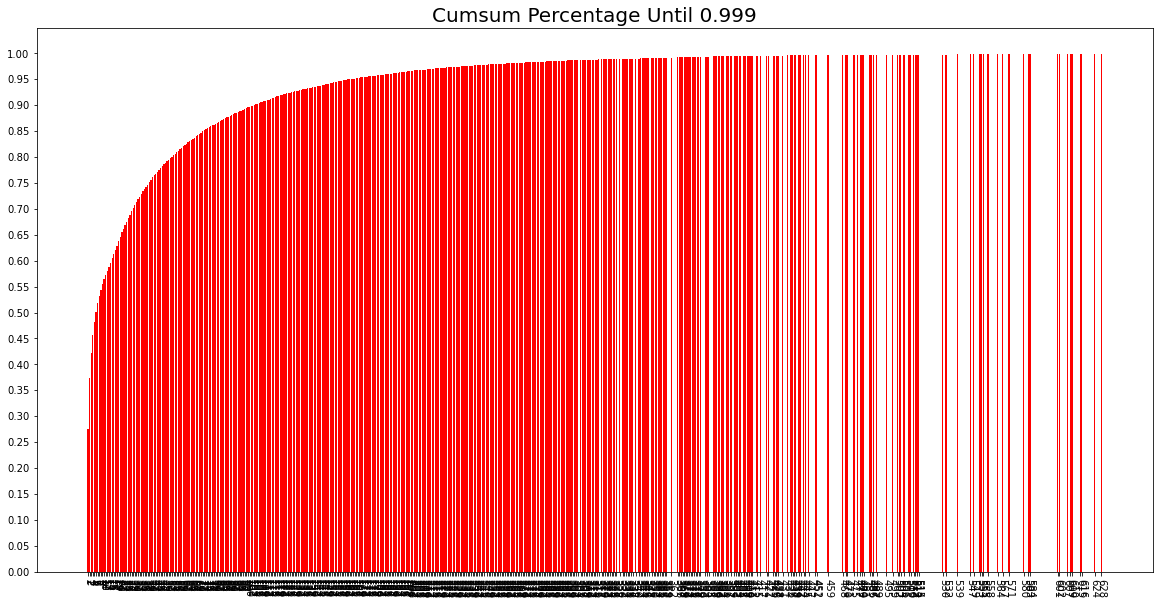

In [14]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index, rotation=-90)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [15]:
# 데이터의 시간 관련 정보
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [16]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

- 3년치 데이터 중에서도 평점이 3 이상인 데이터들만 사용하므로 전체 데이터에 대해서 학습을 진행하기로 판단.

In [17]:
# # 정확도 측정을 위해 우선 2년치 데이터로 해보고 파일을 새로 생성해서 전체 데이터로도 진행해볼 것!
# month_ago = latest - dt.timedelta(730)  # 최종 날짜로부터 2년 이전 날짜를 구한다.  
# data = data[data['DateTime'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
# data
# # len(data)

In [18]:
# # short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# # 이를 위해 반복문을 통해 지속적으로 제거 합니다.
# def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
#     while True:
#         before_len = len(data)
#         data = cleanse_short_session(data, shortest)
#         # data = cleanse_unpopular_item(data, least_click)
#         after_len = len(data)
#         if before_len == after_len:
#             break
#     return data


# def cleanse_short_session(data: pd.DataFrame, shortest):
#     session_len = data.groupby('SessionId').size()
#     session_use = session_len[session_len >= shortest].index
#     data = data[data['SessionId'].isin(session_use)]
#     return data


# def cleanse_unpopular_item(data: pd.DataFrame, least_click):
#     item_popular = data.groupby('ItemId').size()
#     item_use = item_popular[item_popular >= least_click].index
#     data = data[data['ItemId'].isin(item_use)]
#     return data

In [19]:
# new_data = cleanse_recursive(data, shortest=2, least_click=5)
# new_data.shape

In [20]:
data['Time'].max() - data['Time'].min()

Timedelta('1038 days 18:44:18')

In [21]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [86]:
train, test = split_by_date(data, n_days=1038*0.79)
train, valid = split_by_date(train, n_days=1038*0.01)

In [87]:
print(train.shape)
print("Sessions : ", train['SessionId'].nunique())
print("Items : ", train['ItemId'].nunique())
print("First Time : ", train['Time'].min())
print("Last Time : ", train['Time'].max())

(520369, 5)
Sessions :  8980
Items :  3515
First Time :  2000-04-25 23:05:32
Last Time :  2000-11-20 08:03:44


In [88]:
print(valid.shape)
print("Sessions : ", valid['SessionId'].nunique())
print("Items : ", valid['ItemId'].nunique())
print("First Time : ", valid['Time'].min())
print("Last Time : ", valid['Time'].max())

(140815, 5)
Sessions :  2157
Items :  3296
First Time :  2000-11-20 03:52:36
Last Time :  2000-11-30 17:13:06


In [89]:
print(test.shape)
print("Sessions : ", test['SessionId'].nunique())
print("Items : ", test['ItemId'].nunique())
print("First Time : ", test['Time'].min())
print("Last Time : ", test['Time'].max())

(175086, 5)
Sessions :  12223
Items :  3375
First Time :  2000-11-30 17:20:08
Last Time :  2003-02-28 17:49:50


In [90]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

In [91]:
train = indexing(train, id2idx)
valid = indexing(valid, id2idx)
test = indexing(test, id2idx)

In [92]:
train

,UserId,ItemId,Rating,Time,SessionId,item_idx
285653,1702,1193,5,2000-11-20 07:58:36,7272,0
285629,1702,780,5,2000-11-20 07:59:34,7272,1
285639,1702,252,5,2000-11-20 07:59:34,7272,2
285654,1702,1196,4,2000-11-20 07:59:34,7272,3
285621,1702,3793,5,2000-11-20 08:01:39,7272,4
...,...,...,...,...,...,...
1000075,6040,1273,4,2000-07-28 23:58:54,23389,1229
1000188,6040,535,4,2000-07-28 23:58:54,23389,1106
1000191,6040,3751,4,2000-07-28 23:59:42,23389,865
1000194,6040,1077,5,2000-07-28 23:59:59,23389,1149


In [93]:
valid

,UserId,ItemId,Rating,Time,SessionId,item_idx
102883,680,1674,5,2000-11-30 17:03:05,2681,496
102879,680,1291,4,2000-11-30 17:03:42,2681,156
102895,680,1197,5,2000-11-30 17:03:42,2681,7
102887,680,260,5,2000-11-30 17:04:09,2681,13
102904,680,319,3,2000-11-30 17:04:09,2681,1560
...,...,...,...,...,...,...
982280,5927,3949,5,2000-11-21 17:38:29,23023,137
982217,5927,3893,4,2000-11-21 17:38:43,23023,139
982273,5927,3911,4,2000-11-21 17:38:43,23023,310
982274,5927,3914,4,2000-11-21 17:38:56,23023,311


In [94]:
test

,UserId,ItemId,Rating,Time,SessionId,item_idx
31,1,3186,4,2000-12-31 22:00:19,1,2267
22,1,1270,5,2000-12-31 22:00:55,1,159
27,1,1721,4,2000-12-31 22:00:55,1,158
37,1,1022,5,2000-12-31 22:00:55,1,284
24,1,2340,3,2000-12-31 22:01:43,1,668
...,...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,23391,1218
999988,6040,1921,4,2001-08-10 14:41:04,23391,254
1000172,6040,1784,3,2001-08-10 14:41:04,23391,441
1000167,6040,161,3,2001-08-10 14:41:26,23391,680


In [95]:
save_path = data_path / 'project'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
valid.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Data Pipeline

## Session Dataset

In [96]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [97]:
tr_dataset = SessionDataset(train)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
285653,1702,1193,5,2000-11-20 07:58:36,7272,0
285629,1702,780,5,2000-11-20 07:59:34,7272,1
285639,1702,252,5,2000-11-20 07:59:34,7272,2
285654,1702,1196,4,2000-11-20 07:59:34,7272,3
285621,1702,3793,5,2000-11-20 08:01:39,7272,4
285656,1702,839,4,2000-11-20 08:01:39,7272,5
285692,1702,1049,4,2000-11-20 08:01:39,7272,6
285706,1703,1197,5,2000-11-20 07:55:26,7275,7
285718,1703,1924,5,2000-11-20 07:55:26,7275,8
285720,1703,1961,4,2000-11-20 07:55:26,7275,9


In [98]:
tr_dataset.click_offsets

array([     0,      7,     32, ..., 520349, 520356, 520369], dtype=int32)

In [99]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 8977, 8978, 8979])

## SessionData Loader

In [100]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [101]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
285653,1702,1193,5,2000-11-20 07:58:36,7272,0
285629,1702,780,5,2000-11-20 07:59:34,7272,1
285639,1702,252,5,2000-11-20 07:59:34,7272,2
285654,1702,1196,4,2000-11-20 07:59:34,7272,3
285621,1702,3793,5,2000-11-20 08:01:39,7272,4
285656,1702,839,4,2000-11-20 08:01:39,7272,5
285692,1702,1049,4,2000-11-20 08:01:39,7272,6
285706,1703,1197,5,2000-11-20 07:55:26,7275,7
285718,1703,1924,5,2000-11-20 07:55:26,7275,8
285720,1703,1961,4,2000-11-20 07:55:26,7275,9


In [102]:
iter_ex = iter(tr_data_loader)

In [103]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  7 32 45]
Label Item Idx are :       [ 1  8 33 46]
Previous Masked Input Idx are []


# Modeling

## Evaluation Metric

In [104]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## Model Architecture

In [105]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [106]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, valid, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=15, k=20)

In [107]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 3515)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      535050    
_________________________________________________________________
dropout (Dropout)            (32, 50)                  0         
_________________________________________________________________
dense (Dense)                (32, 3515)                179265    
Total params: 714,315
Trainable params: 714,315
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [108]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [109]:
# 학습 시간이 다소 오래 소요됩니다.
train_model(model, args)

Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.51]

	 - Recall@20 epoch 1: 0.247148
	 - MRR@20    epoch 1: 0.063036



Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0.156, train_loss=5.69] 

	 - Recall@20 epoch 2: 0.297327
	 - MRR@20    epoch 2: 0.081887



Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.6] 

	 - Recall@20 epoch 3: 0.317781
	 - MRR@20    epoch 3: 0.091579



Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0.188, train_loss=5.39] 

	 - Recall@20 epoch 4: 0.325608
	 - MRR@20    epoch 4: 0.096195



Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0.188, train_loss=5.18] 

	 - Recall@20 epoch 5: 0.330306
	 - MRR@20    epoch 5: 0.098406



Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0.156, train_loss=5.25] 

	 - Recall@20 epoch 6: 0.332604
	 - MRR@20    epoch 6: 0.099629



Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0.156, train_loss=5.12] 

	 - Recall@20 epoch 7: 0.332611
	 - MRR@20    epoch 7: 0.100151



Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0.156, train_loss=5.05] 

	 - Recall@20 epoch 8: 0.333093
	 - MRR@20    epoch 8: 0.100387



Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.08]

	 - Recall@20 epoch 9: 0.332815
	 - MRR@20    epoch 9: 0.100375



Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.14]

	 - Recall@20 epoch 10: 0.331415
	 - MRR@20    epoch 10: 0.100687



Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.23]

	 - Recall@20 epoch 11: 0.331028
	 - MRR@20    epoch 11: 0.101160



Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0, train_loss=5.83]     

	 - Recall@20 epoch 12: 0.330452
	 - MRR@20    epoch 12: 0.100852



Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.35]

	 - Recall@20 epoch 13: 0.329540
	 - MRR@20    epoch 13: 0.100644



Train:   0%|          | 0/15980 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.87]

	 - Recall@20 epoch 14: 0.329219
	 - MRR@20    epoch 14: 0.100391



Evaluation:  99%|█████████▉| 4284/4333 [07:08<00:04, 10.01it/s]

	 - Recall@20 epoch 15: 0.327862
	 - MRR@20    epoch 15: 0.100098



In [110]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  99%|█████████▉| 5049/5089 [08:46<00:04,  9.58it/s]

	 - Recall@20: 0.252810
	 - MRR@20: 0.072666



- epoch 15번만에 MRR과 Recall이 상승하다가 약간 떨어지는 구간을 만났다. batch size를 작게 주었기 때문에 local minimum에 있을 수 있다.

### 모델 수정 2nd
- batch_size : 64, drop_rate = 0.15, epochs = 25

In [117]:
args = Args(train, valid, test, batch_size=64, hsz=50, drop_rate=0.15, lr=0.001, epochs=25, k=20)
model = create_model(args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(64, 1, 3515)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      535050    
_________________________________________________________________
dropout_3 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (64, 3515)                179265    
Total params: 714,315
Trainable params: 714,315
Non-trainable params: 0
_________________________________________________________________


In [118]:
train_model(model, args)

Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0, train_loss=6.47]     

	 - Recall@20 epoch 1: 0.211891
	 - MRR@20    epoch 1: 0.052145



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.85]

	 - Recall@20 epoch 2: 0.283112
	 - MRR@20    epoch 2: 0.076164



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.75]

	 - Recall@20 epoch 3: 0.310601
	 - MRR@20    epoch 3: 0.087589



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.61]

	 - Recall@20 epoch 4: 0.327172
	 - MRR@20    epoch 4: 0.094998



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.57]

	 - Recall@20 epoch 5: 0.335200
	 - MRR@20    epoch 5: 0.098734



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.51]

	 - Recall@20 epoch 6: 0.339974
	 - MRR@20    epoch 6: 0.101754



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.6] 

	 - Recall@20 epoch 7: 0.342469
	 - MRR@20    epoch 7: 0.103390



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.57]

	 - Recall@20 epoch 8: 0.343616
	 - MRR@20    epoch 8: 0.104357



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.58]

	 - Recall@20 epoch 9: 0.344405
	 - MRR@20    epoch 9: 0.105000



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.25]

	 - Recall@20 epoch 10: 0.344785
	 - MRR@20    epoch 10: 0.105273



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.47]

	 - Recall@20 epoch 11: 0.345329
	 - MRR@20    epoch 11: 0.105839



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.125, train_loss=5]    

	 - Recall@20 epoch 12: 0.345657
	 - MRR@20    epoch 12: 0.105925



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.27]

	 - Recall@20 epoch 13: 0.345649
	 - MRR@20    epoch 13: 0.105969



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0469, train_loss=4.98]

	 - Recall@20 epoch 14: 0.344741
	 - MRR@20    epoch 14: 0.105757



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.141, train_loss=4.94] 

	 - Recall@20 epoch 15: 0.345739
	 - MRR@20    epoch 15: 0.105962



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0, train_loss=5.22]     

	 - Recall@20 epoch 16: 0.345426
	 - MRR@20    epoch 16: 0.106474



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.34]

	 - Recall@20 epoch 17: 0.343772
	 - MRR@20    epoch 17: 0.106386



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.93] 

	 - Recall@20 epoch 18: 0.343735
	 - MRR@20    epoch 18: 0.106218



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.12]

	 - Recall@20 epoch 19: 0.343802
	 - MRR@20    epoch 19: 0.106499



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.141, train_loss=5.13] 

	 - Recall@20 epoch 20: 0.343177
	 - MRR@20    epoch 20: 0.106009



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.109, train_loss=5.01] 

	 - Recall@20 epoch 21: 0.342059
	 - MRR@20    epoch 21: 0.106013



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.88]

	 - Recall@20 epoch 22: 0.343244
	 - MRR@20    epoch 22: 0.106335



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.91]

	 - Recall@20 epoch 23: 0.342193
	 - MRR@20    epoch 23: 0.106271



Train:   0%|          | 0/7990 [00:00<?, ?it/s, accuracy=0.109, train_loss=4.92] 

	 - Recall@20 epoch 24: 0.341702
	 - MRR@20    epoch 24: 0.105733



Evaluation:  97%|█████████▋| 2098/2166 [07:07<00:13,  4.90it/s]

	 - Recall@20 epoch 25: 0.341493
	 - MRR@20    epoch 25: 0.105877



In [119]:
test_model(model, args, test)

Evaluation:  99%|█████████▊| 2508/2544 [09:02<00:07,  4.62it/s]

	 - Recall@20: 0.258031
	 - MRR@20: 0.074548



- batch를 조금 늘리고 대신, epoch를 늘려서 학습시켜보았다.(+ Dropout 층의 rate 역시 약간 조절해봄.) 여전히 15번째 epoch쯤 최대치를 뽑아내는 것 같다. (batch사이즈를 더 늘려보고 global optimum을 찾아내는지 확인해보자!)

### 모델 수정 3rd
- batch_size : 128, drop_rate = 0.1, epochs = 20

In [114]:
args = Args(train, valid, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3515)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    535050    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3515)               179265    
Total params: 714,315
Trainable params: 714,315
Non-trainable params: 0
_________________________________________________________________


In [115]:
train_model(model, args)

Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.34] 

	 - Recall@20 epoch 1: 0.154365
	 - MRR@20    epoch 1: 0.036234



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.89] 

	 - Recall@20 epoch 2: 0.259085
	 - MRR@20    epoch 2: 0.067449



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.32] 

	 - Recall@20 epoch 3: 0.296084
	 - MRR@20    epoch 3: 0.081062



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.18] 

	 - Recall@20 epoch 4: 0.316720
	 - MRR@20    epoch 4: 0.089578



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.2]  

	 - Recall@20 epoch 5: 0.330072
	 - MRR@20    epoch 5: 0.095929



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.96]

	 - Recall@20 epoch 6: 0.338459
	 - MRR@20    epoch 6: 0.099933



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.1]  

	 - Recall@20 epoch 7: 0.343758
	 - MRR@20    epoch 7: 0.102970



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.06] 

	 - Recall@20 epoch 8: 0.347102
	 - MRR@20    epoch 8: 0.104670



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.03]

	 - Recall@20 epoch 9: 0.348087
	 - MRR@20    epoch 9: 0.105739



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.02]

	 - Recall@20 epoch 10: 0.349840
	 - MRR@20    epoch 10: 0.106982



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.109, train_loss=4.97]  

	 - Recall@20 epoch 11: 0.350787
	 - MRR@20    epoch 11: 0.107549



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0859, train_loss=4.92]

	 - Recall@20 epoch 12: 0.351151
	 - MRR@20    epoch 12: 0.108087



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.63] 

	 - Recall@20 epoch 13: 0.350794
	 - MRR@20    epoch 13: 0.108114



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.99] 

	 - Recall@20 epoch 14: 0.349840
	 - MRR@20    epoch 14: 0.108486



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.95]

	 - Recall@20 epoch 15: 0.350251
	 - MRR@20    epoch 15: 0.108726



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.102, train_loss=4.88]  

	 - Recall@20 epoch 16: 0.350135
	 - MRR@20    epoch 16: 0.108736



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.102, train_loss=4.87] 

	 - Recall@20 epoch 17: 0.349468
	 - MRR@20    epoch 17: 0.108924



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.12]

	 - Recall@20 epoch 18: 0.350050
	 - MRR@20    epoch 18: 0.109076



Train:   0%|          | 0/3995 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.76] 

	 - Recall@20 epoch 19: 0.349150
	 - MRR@20    epoch 19: 0.109011



Evaluation:  93%|█████████▎| 1007/1083 [05:52<00:26,  2.86it/s]

	 - Recall@20 epoch 20: 0.349103
	 - MRR@20    epoch 20: 0.109018



In [116]:
test_model(model, args, test)

Evaluation:  97%|█████████▋| 1236/1272 [07:39<00:13,  2.69it/s]

	 - Recall@20: 0.260998
	 - MRR@20: 0.076044



- 끝으로 batch size를 128정도로 주고, drop rate는 0.1로 재조정한 뒤 20정도의 epoch로 학습시켜 보았다. 20 epoch까지 자는 동안 Recall과 MRR이 계속 상승하는 것을 확인하였다.

batch_size = 128, drop_rate = 0.1, epoch = 30
이정도 하이퍼파라미터로 더 많은 학습을 주게 되면 성능이 아주 조금 더 상승할 것 같기도 하다.

# 회고

## * 이번 프로젝트에서 어려웠던 점.
    
    노드에서는 세션에 대한 명확한 데이터를 가지고 실습했는데, 막상 프로젝트는 그러한 세션에 대해 명확하게 할 지표가 존재하지 않아서 feature 생성을 어떻게 하는게 좋을지 막막했다. 
    

## * 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.
    
    일단 느리다. 그렇다고 또 batch size를 너무 크게 주면, 학습 자체가 되지 않는다. (데이터셋의 비율을 따로 고려해야하기 때문) 그리고 testset의 크기가 클 수록 자연스럽게 모델의 성능이 오른다는 것을 확인하였다. (뭔가 테스트셋이 많으면 그만큼 맞춰야 할 지표가 늘어나는 거니까 성능평가가 좋지 않을거라고 생각했는데, RNN의 경우는 조금 다른건가?!)
    

## * 루브릭 평가 지표를 맞추기 위해 시도한 것들.
    
    1) Movielens 데이터셋을 Session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었는가? (데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.)
    
    Yes.
    
    2) RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었는가? (적절한 epoch 만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.)
    
    Yes.
    
    3) 세션정의, 모델구조, 하이퍼파라미터 등을 변경해 실험하여 Recall, MRR 등의 변화 추이를 관찰하였는가? (3가지 이상의 변화를 시도하고, 그 실험 결과를 체계적으로 분석하였다.)
    
    Yes.
